In [121]:
import sys
sys.path.append('../')
import numpy as np

def build_tree(n_levels, n_branches, probability,
               to_np_array=True):
  """
  Builds tree

  Args:
    n_levels: int
      Number of levels in tree
    n_branches: int
      Number of branches in tree
    probability: float
      Flipping probability
    to_np_array: boolean
      If true, represent tree as np.ndarray

  Returns:
    tree: dict if to_np_array=False
          np.ndarray otherwise
      Tree
  """
  assert 0.0 <= probability <= 1.0

  tree = {}

  tree["level"] = [0]
  for i in range(1, n_levels+1):
    tree["level"].extend([i]*(n_branches**i))

  tree["pflip"] = [probability]*len(tree["level"])

  tree["parent"] = [None]
  k = len(tree["level"])-1
  for j in range(k//n_branches):
    tree["parent"].extend([j]*n_branches)

  if to_np_array:
    tree["level"] = np.array(tree["level"])
    tree["pflip"] = np.array(tree["pflip"])
    tree["parent"] = np.array(tree["parent"])

  return tree


def sample_from_tree(tree, n):
  """
  Generates n samples from a tree

  Args:
    tree: np.ndarray/dictionary
      Tree
    n: int
      Number of levels in tree

  Returns:
    x: np.ndarray
      Sample from tree
  """
  items = [i for i, v in enumerate(tree["level"]) if v == max(tree["level"])]
  n_items = len(items)
  x = np.zeros(shape=(n, n_items))
  rand_temp = np.random.rand(n, len(tree["pflip"]))
  flip_temp = np.repeat(tree["pflip"].reshape(1, -1), n, 0)
  samp = (rand_temp > flip_temp) * 2 - 1

  for i in range(n_items):
    j = items[i]
    prop = samp[:, j]
    while tree["parent"][j] is not None:
      j = tree["parent"][j]
      prop = prop * samp[:, j]
    x[:, i] = prop.T
  return x

def generate_hsd():
  """
  Building the tree

  Args:
    None

  Returns:
    tree_labels: np.ndarray
      Tree Labels
    tree_features: np.ndarray
      Sample from tree
  """
  n_branches = 2  # 2 branches at each node
  probability = .15  # flipping probability
  n_levels = 3  # number of levels (depth of tree)
  tree = build_tree(n_levels, n_branches, probability, to_np_array=True)
  tree["pflip"][0] = 0.5
  n_samples = 10000 # Sample this many features

  tree_labels = np.eye(n_branches**n_levels)
  tree_features = sample_from_tree(tree, n_samples).T
  return tree_labels, tree_features



In [37]:
import numpy as np
import math

n_items = 4
assert math.log(n_items, 2) % 1 == 0
n_features = 2**(n_items - 1) - 1

features = np.zeros((n_features, n_items))
print(features)

item_ids = [1, 2, 3, 4]

print(np.eye(2))


[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1. 0.]
 [0. 1.]]


In [40]:
features = np.zeros((n_features, n_items))

row = 0

def hsd(n_items):
    power = int(math.log(n_items, 2))
    assert power % 1 == 0
    n_features = 2**(power + 1) - 1

    tree_features = np.zeros((n_features, n_items))    
    row = 0
    
    freqs = np.logspace(0, power, power+1, base=2, dtype=np.int64)
    
    for freq in freqs:
        span = int(n_items/freq)

        for blocks in range(freq):
            tree_features[row, blocks*span : (blocks+1)*span] = 1  
            row += 1
            
    tree_labels = np.eye(n_items)
            
    return tree_labels, tree_features

def hsd_context(n_items, n_contexts, symmetry=True):
    tree_labels_all, tree_features_all = [], []
    
    for c in range(n_contexts):
        tree_labels, tree_features = hsd(n_items)
        tree_features_all.append(tree_features)
        
    tree_features_all = np.concatenate(tree_features_all, axis=0)
    return tree_labels, tree_features_all

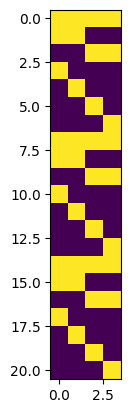

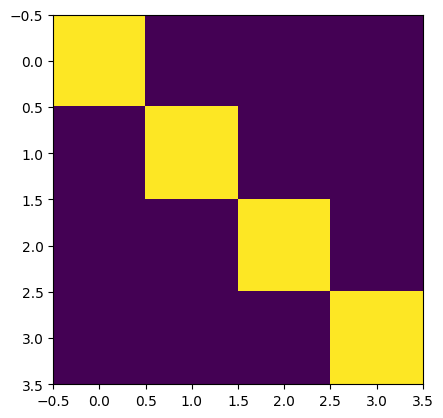

In [88]:
import plotting_functions as pf
import matplotlib.pyplot as plt
tree_labels, tree_features_all = hsd_context(4,3)
plt.imshow(tree_features_all)
plt.show()
plt.imshow(tree_labels)
plt.show()

# Convert (cast) data from np.ndarray to torch.Tensor
label_tensor = torch.tensor(tree_labels).float()
feature_tensor = torch.tensor(tree_features_all).float()

In [103]:
%load_ext autoreload
%autoreload 2

import sys
import torch
sys.path.append('../')
from GLNNet import GLNNet

model = GLNNet(dims=(4,30,45,21), pathways=(1,1,3,3))
print(len(model.layers))
x = torch.Tensor([1,0,0,0])
g = (None,None,0,0)
model.forward(x, g)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3


(tensor([ 0.0932,  0.0773, -0.1010, -0.0305,  0.0195,  0.0129,  0.0586, -0.0000,
          0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.0000, -0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.0000], grad_fn=<MulBackward0>),
 [tensor([1., 0., 0., 0.]),
  tensor([ 0.2080,  0.4908,  0.3239,  0.1367, -0.2176,  0.4186,  0.4838,  0.0561,
           0.4337,  0.0878, -0.4707,  0.2496,  0.4295, -0.3048, -0.4267, -0.1167,
          -0.3520,  0.1489,  0.3056, -0.0158, -0.1401,  0.1531, -0.3730, -0.0733,
           0.2550, -0.1225,  0.3300, -0.0677, -0.3618,  0.3947],
         grad_fn=<MulBackward0>),
  tensor([ 0.0678,  0.0354, -0.1694,  0.1049,  0.2269,  0.2134, -0.1193, -0.0164,
           0.0938,  0.0307, -0.0132, -0.4057,  0.0168, -0.2211, -0.1420,  0.0000,
          -0.0000, -0.0000,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000,
           0.0000, -0.0000,  0.0000, -0.0000,  0.0000,  0.0000, -0.0000, -0.0000,
          -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0

In [104]:
item = 0
x = label_tensor[:, item]
y = feature_tensor[:, item]

print(x, y)

tensor([1., 0., 0., 0.]) tensor([1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
        0., 0., 0.])


In [106]:
import torch.optim as optim
from torch import nn
n_epochs=1
lr=100
losses = np.zeros(n_epochs)  # Loss records
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.MSELoss()

optimizer.zero_grad()
predictions, hiddens, _ = model(x, g)
print(predictions.shape, y.shape)
loss = criterion(predictions, y)
loss.backward()
optimizer.step()

print(loss)

(None, None, 0, 0)
torch.Size([21]) torch.Size([21])
tensor(359.5018, grad_fn=<MseLossBackward0>)


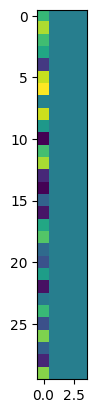

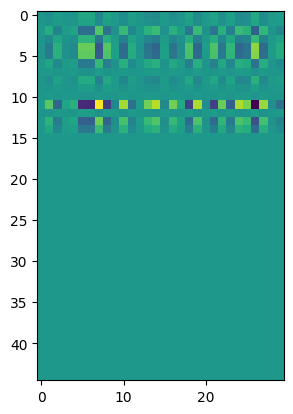

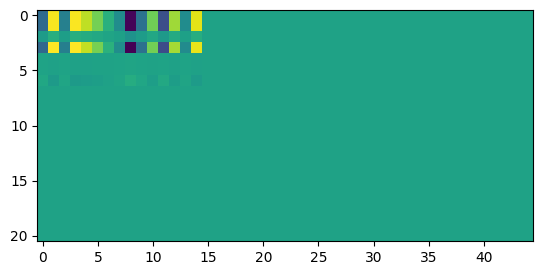

[None, None, None]

In [107]:
grads = [weight.grad for weight in model.parameters()]

def plot_grad(grad):
    plt.imshow(grad)
    plt.show()
    
[plot_grad(grad) for grad in grads]